Generating mlp parameters...
    cond thresh: 17.055634
    L0: cond=68.789569
    L0: cond=23.433151
    L0: cond=11.984876
    L0s: cond=23.196500
    L0s: cond=13.882289
    L1: cond=238.741581
    L1: cond=43.816264
    L1: cond=456.809691
    L1: cond=22.566767
    L1: cond=22.610590
    L1: cond=38.827999
    L1: cond=11.968617
Generating source...
PCA...
    num_comp=10
    use learned value
h_val shape: (32767, 10)
s shape: (10, 32768)
h_val shape: (32767, 10)
s_for_corr shape: (32767, 10)
Calculating correlation...

Correlation matrix (diagonal = optimal alignment):
[[-0.961  0.048  0.016 -0.064 -0.056 -0.02  -0.015  0.053  0.02   0.032]
 [ 0.037 -0.973 -0.061 -0.004 -0.02  -0.068 -0.039 -0.063  0.006  0.017]
 [-0.039 -0.008  0.974 -0.034  0.017  0.071 -0.013  0.076  0.012 -0.026]
 [ 0.06   0.024 -0.015  0.983 -0.04  -0.005 -0.028 -0.011  0.048 -0.056]
 [ 0.052 -0.006  0.009 -0.045  0.957 -0.019 -0.075 -0.021  0.024 -0.058]
 [ 0.011 -0.028 -0.042  0.017  0.048 -0.944  0.002  0

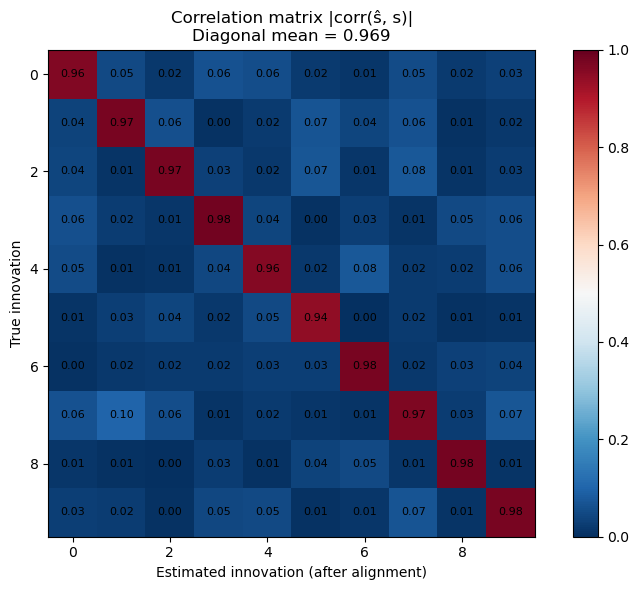

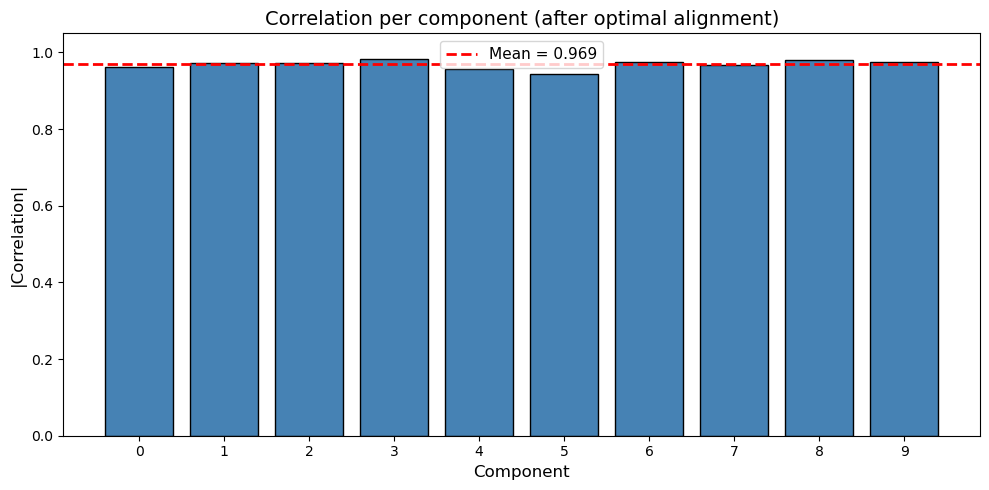

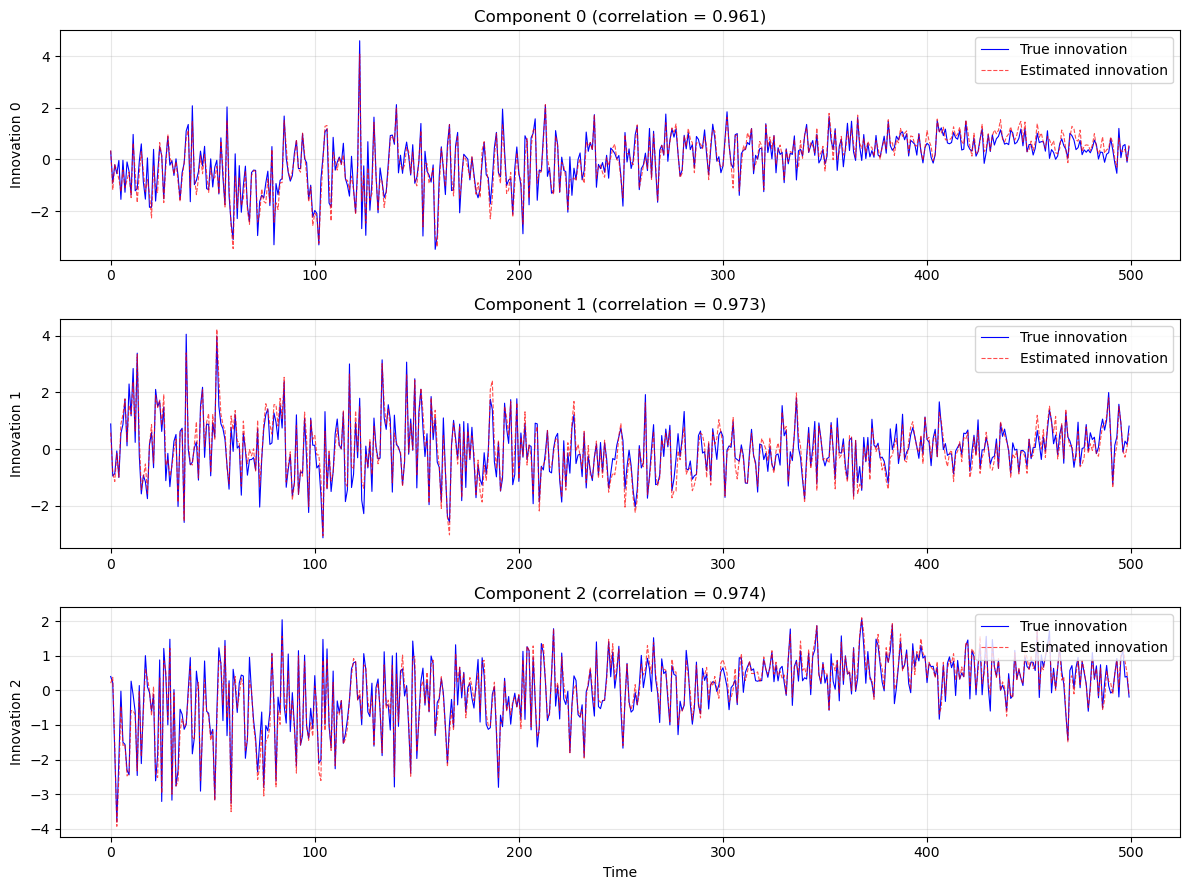


RESULTS SUMMARY
Dimension: 10
Number of data points: 32768
Mean correlation: 0.9692
Min correlation: 0.9444
Max correlation: 0.9833
Standard deviation: 0.0112


In [1]:
"""
Analysis of IIA-GCL Results on Simulated Data
"""
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

from subfunc.generate_artificial_data import generate_artificial_data
from subfunc.preprocessing import pca
from igcl import igcl, utils

# ============================================================
# 1. Load Parameters and Model
# ============================================================

eval_dir = './storage/model_20251230_012619'
parmpath = os.path.join(eval_dir, 'parm.pkl')
modelpath = os.path.join(eval_dir, 'model.pt')

with open(parmpath, 'rb') as f:
    model_parm = pickle.load(f)

num_comp = model_parm['num_comp']
num_data = model_parm['num_data']
ar_order = model_parm['ar_order']
num_basis = model_parm['num_basis']
list_hidden_nodes = model_parm['list_hidden_nodes']
list_hidden_nodes_z = model_parm.get('list_hidden_nodes_z')
random_seed = model_parm['random_seed']
pca_parm = model_parm['pca_parm']

# ============================================================
# 2. Regenerate the Same Data
# ============================================================

x, s, y, _, _, _, _, _, _ = generate_artificial_data(
    num_comp=num_comp,
    num_data=num_data,
    num_layer=model_parm['num_layer'],
    num_basis=num_basis,
    modulate_range1=model_parm['modulate_range'],
    modulate_range2=model_parm['modulate_range2'],
    random_seed=random_seed
)

x, _ = pca(x, num_comp=num_comp, params=pca_parm)
x = x.T  # (num_data, num_comp)

# ============================================================
# 3. Load Model
# ============================================================

if list_hidden_nodes_z is None:
    list_hidden_nodes_z = list_hidden_nodes.copy()

model = igcl.NetGaussScaleMean(
    h_sizes=list_hidden_nodes,
    h_sizes_z=list_hidden_nodes_z,
    ar_order=ar_order,
    num_dim=x.shape[1],
    num_data=num_data,
    num_basis=num_basis
)

checkpoint = torch.load(modelpath, map_location='cpu')
model.load_state_dict(checkpoint['ema_state_dict'])
model.eval()

# ============================================================
# 4. Prepare AR Data
# ============================================================

t_idx = np.arange(x.shape[0] - ar_order) + ar_order
t_idx = t_idx.reshape([-1, 1]) + np.arange(0, -ar_order - 1, -1).reshape([1, -1])
x_ar = x[t_idx.reshape(-1), :].reshape([-1, ar_order + 1, x.shape[-1]])
y_ar = y[t_idx[:, 0]]

# Forward pass
x_torch = torch.from_numpy(x_ar.astype(np.float32))
y_torch = torch.from_numpy(y_ar).type(torch.LongTensor)

with torch.no_grad():
    logits, h, hz, _, _ = model(x_torch, y_torch)
    # Split to retrieve only true predictions (not shuffled ones)
    h, h_star = torch.split(h, split_size_or_sections=int(h.size()[0]//2), dim=0)

h_val = np.squeeze(h.numpy())

print(f"h_val shape: {h_val.shape}")
print(f"s shape: {s.shape}")

# ============================================================
# 5. Compute Correlation
# ============================================================
s_for_corr = s[:, :-1].T  # (num_data-1, num_comp)

print(f"h_val shape: {h_val.shape}")
print(f"s_for_corr shape: {s_for_corr.shape}")

corrmat, sort_idx, h_sorted = utils.correlation(h_val, s_for_corr, 'Pearson')

print("\nCorrelation matrix (diagonal = optimal alignment):")
print(np.round(corrmat, 3))

mean_corr = np.mean(np.abs(np.diag(corrmat)))
print(f"\nMean correlation: {mean_corr:.4f}")

# ============================================================
# 6. Figures
# ============================================================

# Figure 1: Correlation Matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.abs(corrmat), cmap='RdBu_r', vmin=0, vmax=1)
ax.set_xlabel('Estimated innovation (after alignment)')
ax.set_ylabel('True innovation')
ax.set_title(f'Correlation matrix |corr(ŝ, s)|\nDiagonal mean = {mean_corr:.3f}')
plt.colorbar(im, ax=ax)

for i in range(num_comp):
    for j in range(num_comp):
        ax.text(j, i, f'{np.abs(corrmat[i,j]):.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('fig_correlation_matrix_simulated.png', dpi=150)
plt.savefig('fig_correlation_matrix_simulated.pdf')
plt.show()

# Figure 2: Correlation per Component
diag_corr = np.abs(np.diag(corrmat))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(num_comp), diag_corr, color='steelblue', edgecolor='black')
ax.axhline(y=mean_corr, color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {mean_corr:.3f}')
ax.set_xlabel('Component', fontsize=12)
ax.set_ylabel('|Correlation|', fontsize=12)
ax.set_title('Correlation per component (after optimal alignment)', fontsize=14)
ax.set_ylim([0, 1.05])
ax.legend(fontsize=11)
ax.set_xticks(range(num_comp))

plt.tight_layout()
plt.savefig('fig_correlation_per_component.png', dpi=150)
plt.savefig('fig_correlation_per_component.pdf')
plt.show()

# Figure 3: Temporal Comparison
n_show = 3
t_range = np.arange(500)

fig, axes = plt.subplots(n_show, 1, figsize=(12, 3*n_show))

s_aligned = s[:, :-1]  # (num_comp, num_data-1)

for i in range(n_show):
    corr_val = corrmat[i, i]
    
    s_i = s_aligned[i, t_range]
    h_i = h_sorted[i, t_range]
    
    # Normalize
    s_norm = (s_i - np.mean(s_i)) / np.std(s_i)
    h_norm = (h_i - np.mean(h_i)) / np.std(h_i)
    
    # Adjust sign if correlation is negative
    if corr_val < 0:
        h_norm = -h_norm
    
    axes[i].plot(t_range, s_norm, 'b-', linewidth=0.8, label='True innovation')
    axes[i].plot(t_range, h_norm, 'r--', linewidth=0.8, alpha=0.7, label='Estimated innovation')
    axes[i].set_ylabel(f'Innovation {i}')
    axes[i].set_title(f'Component {i} (correlation = {np.abs(corr_val):.3f})')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.savefig('fig_innovations_comparison.png', dpi=150)
plt.savefig('fig_innovations_comparison.pdf')
plt.show()

# ============================================================
# 7. Summary
# ============================================================

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(f"Dimension: {num_comp}")
print(f"Number of data points: {num_data}")
print(f"Mean correlation: {mean_corr:.4f}")
print(f"Min correlation: {np.min(diag_corr):.4f}")
print(f"Max correlation: {np.max(diag_corr):.4f}")
print(f"Standard deviation: {np.std(diag_corr):.4f}")
print("="*50)